# XGBoost Experiment

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 95.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Constants

In [4]:
NA_DROP_THRESHOLD = 0.5
CORRELATION_FILTER_THRESHOLD=0.8
KFOLD_N_SPLITS = 3
RANDOM_STATE=42
DATASET_SPLIT_SIZE=0.2

# Load Dataset

In [5]:
# Load each data table
transactions = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
identities = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

# Merge data tables
df = pd.merge(transactions, identities, on="TransactionID", how="left")

# Free up memory
del transactions
del identities

In [6]:
# Separate features and target values
y_total = df["isFraud"]
X_total = df.drop(columns=["isFraud"])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=DATASET_SPLIT_SIZE, random_state=RANDOM_STATE)

In [8]:
X_train.shape, y_train.shape

((472432, 433), (472432,))

In [9]:
X_test.shape, y_test.shape

((118108, 433), (118108,))

# Dagshub Setup

In [11]:
!pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 60.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
 

In [12]:
import dagshub
dagshub.auth.add_app_token('ed22b8f88bed7c968c7425f62448b33703f4e094')
dagshub.init(repo_owner='vvaza22', repo_name='ml-assignment-2', mlflow=True)

Accessing as vvaza22

Initialized MLflow to track repo "vvaza22/ml-assignment-2"

Repository vvaza22/ml-assignment-2 initialized!

In [13]:
import mlflow

def log_model(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("XGBoost_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(best_pipeline, "XGBoost")
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

# Cleaning

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighNAFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self._feats_to_drop = []
        self.threshold = threshold
    
    def fit(self, X, y=None):
        
        na_dist = X.isna().mean()
        for feat, na_ratio in na_dist.items():
            if na_ratio > self.threshold:
                self._feats_to_drop.append(feat)
        
        return self

    def transform(self, X):
        X = X.copy()

        # Drop features with high NA content
        X.drop(columns=self._feats_to_drop, inplace=True)

        return X

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class FillNAWithMedian(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._na_mapping = {}
    
    def fit(self, X, y=None):
        
        for feat in X.columns:
            median = X[feat].median()
            self._na_mapping[feat] = median
        
        return self

    def transform(self, X):
        X = X.copy()

        for feat, value in self._na_mapping.items():
            X[feat] = X[feat].fillna(value)
        
        return X

# Feature Engineering

In [16]:
import category_encoders

# Find every categorical feature in the data
cat_feats = [feat for feat in X_total.columns if X_total[feat].dtype == "object"]

# Create woe encoder for the features
woe_encoder = category_encoders.WOEEncoder(cols=cat_feats)

### Helper Functions

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X, y):
    
    # Predict probabilities
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    
    plt.title("ROC Curve on Training Set")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(fpr, tpr, color="blue")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"xgboost_roc_curve.png")
    plt.show()

    # Draw Mirrored ROC curve
    tnr = 1 - fpr
    plt.figure(figsize=(10, 8))
    
    plt.title("Mirrored ROC Curve on Training Set")
    plt.xlabel('True Negative Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(tnr, tpr, color="red")
    plt.plot([0, 1], [1, 0], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"xgboost_roc_curve_mirrored.png")
    plt.show()

In [18]:
import mlflow

# https://mlflow.org/docs/latest/traditional-ml/creating-custom-pyfunc/notebooks/override-predict/
class ProbabilityModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def load_context(self, context):
        pass

    def predict(self, context, model_input, params=None):
        return self.model.predict_proba(model_input)[:, 1]

/usr/local/lib/python3.11/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [19]:
def log_custom_pymodel(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("XGBoost_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.pyfunc.log_model("XGBoost", python_model=ProbabilityModel(best_pipeline))
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

In [20]:
def get_metrics(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the best result from the grid search
    best_result = results.sort_values(by="rank_test_score").iloc[0].to_dict()

    # Remove parameter values
    keys_to_drop = []
    for key in best_result.keys():
        if key.startswith("param"):
            keys_to_drop.append(key)
    
    for key in keys_to_drop:
        del best_result[key]

    del best_result["rank_test_score"]

    return best_result

# Experiment 1: Training with Default Pipeline

In [ ]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__max_depth": [3],
    "classifier__n_estimators": [300],
    "classifier__learning_rate": [0.3],
    "classifier__gamma": [0.1, 0.2],
    "classifier__alpha": [0],
    "classifier__scale_pos_weight": [5],
    "classifier__lambda": [1],
}

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

model = xgb.XGBClassifier(eval_metric="auc")
pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('scaler', StandardScaler()),
    ('classifier', model),
])

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [ ]:
grid_search.fit(X, y)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [ ]:
best_pipeline = grid_search.best_estimator_
plot_roc(best_pipeline, X, y)

In [ ]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}
params

In [ ]:
metrics = get_metrics(grid_search)
metrics

In [ ]:
best_pipeline = grid_search.best_estimator_

In [ ]:
log_model(
    run_name="XGBoost_Model_2",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["xgboost_roc_curve.png", "xgboost_roc_curve_mirrored.png"]
)

In [ ]:
log_custom_pymodel(
    run_name="XGBoost_Prob_Model_2",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["xgboost_roc_curve.png", "xgboost_roc_curve_mirrored.png"]
)

# Experiment 2: Imbalancecd Learn

## Try Over Sampling with SMOTE

In [10]:
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE

model = xgb.XGBClassifier(eval_metric="auc")
pipeline = ImbalancedPipeline(steps=[
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na', FillNAWithMedian()),
    ('smote', SMOTE(random_state=RANDOM_STATE)), # Try over sampling the minority class
    ('classifier', model),
])

In [11]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__max_depth": [6, 9],
    "classifier__n_estimators": [10, 20, 30],
    "classifier__learning_rate": [0.3],
    "classifier__gamma": [0.1],
    "classifier__alpha": [0],
    "classifier__lambda": [1],
}

In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [13]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END classifier__alpha=0, classifier__gamma=0.1, classifier__lambda=1, classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=10;, score=(train=0.869, test=0.864) total time=  50.6s
[CV 2/3] END classifier__alpha=0, classifier__gamma=0.1, classifier__lambda=1, classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=10;, score=(train=0.868, test=0.867) total time=  45.3s
[CV 3/3] END classifier__alpha=0, classifier__gamma=0.1, classifier__lambda=1, classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=10;, score=(train=0.866, test=0.861) total time=  45.6s
[CV 1/3] END classifier__alpha=0, classifier__gamma=0.1, classifier__lambda=1, classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=20;, score=(train=0.889, test=0.882) total time=  47.7s
[CV 2/3] END classifier__alpha=0, classifier__gamma=0.1, classifier__lambda=

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__alpha': [0], 'classifier__gamma': [0.1],
                         'classifier__lambda': [1],
                         'classifier__learning_rate': [0.3],
                         'classifier__max_depth': [6, 9],
                         'classifier__n_estimators': [10, 20, 30]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [14]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    "pipeline_type": "imbalanced pipeline",
    "oversampler": "smote",
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'pipeline_type': 'imbalanced pipeline',
 'oversampler': 'smote',
 'classifier__alpha': 0,
 'classifier__gamma': 0.1,
 'classifier__lambda': 1,
 'classifier__learning_rate': 0.3,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 30}

In [15]:
from sklearn.metrics import roc_auc_score

best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.9258527768311632

In [21]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 48.67134706179301,
 'std_fit_time': 0.39331257154639,
 'mean_score_time': 3.7316087086995444,
 'std_score_time': 0.18654748488749512,
 'split0_test_score': 0.9249357754675936,
 'split1_test_score': 0.9231656229362597,
 'split2_test_score': 0.9241075644741363,
 'mean_test_score': 0.9240696542926633,
 'std_test_score': 0.0007231587573239536,
 'split0_train_score': 0.9477538432996367,
 'split1_train_score': 0.9517413786066756,
 'split2_train_score': 0.947711437320957,
 'mean_train_score': 0.9490688864090897,
 'std_train_score': 0.0018898166536068799,
 'validation_score': 0.9258527768311632}

In [23]:
import category_encoders

cat_encoder = category_encoders.WOEEncoder(
    cols=[feat for feat in X_train.columns if X_train[feat].dtype == "object"]
)
X_mod = cat_encoder.fit_transform(X_train, y_train)
X_mod = DropHighNAFeatures(threshold=NA_DROP_THRESHOLD).fit_transform(X_mod, y_train)
X_mod = FillNAWithMedian().fit_transform(X_mod, y_train)

In [24]:
import shap
explainer = shap.TreeExplainer(grid_search.best_estimator_.named_steps["classifier"])
shap_values = explainer.shap_values(X_mod)

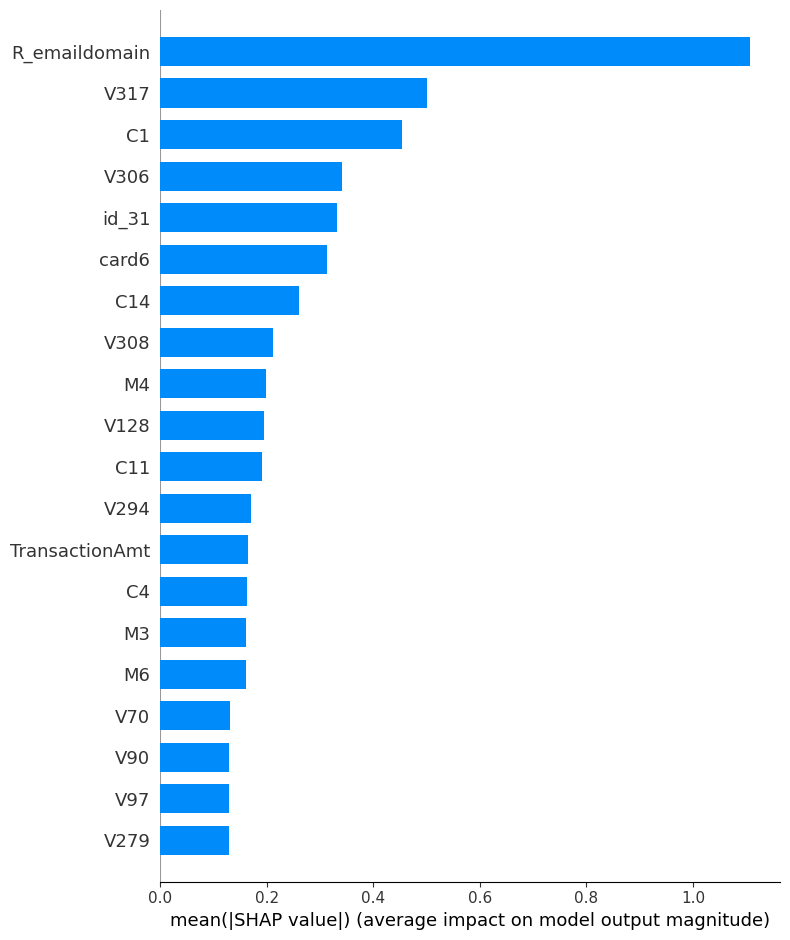

In [31]:
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_mod, plot_type="bar", show=False)
plt.savefig("xgboost_shap_bar_plot.png")
plt.show()

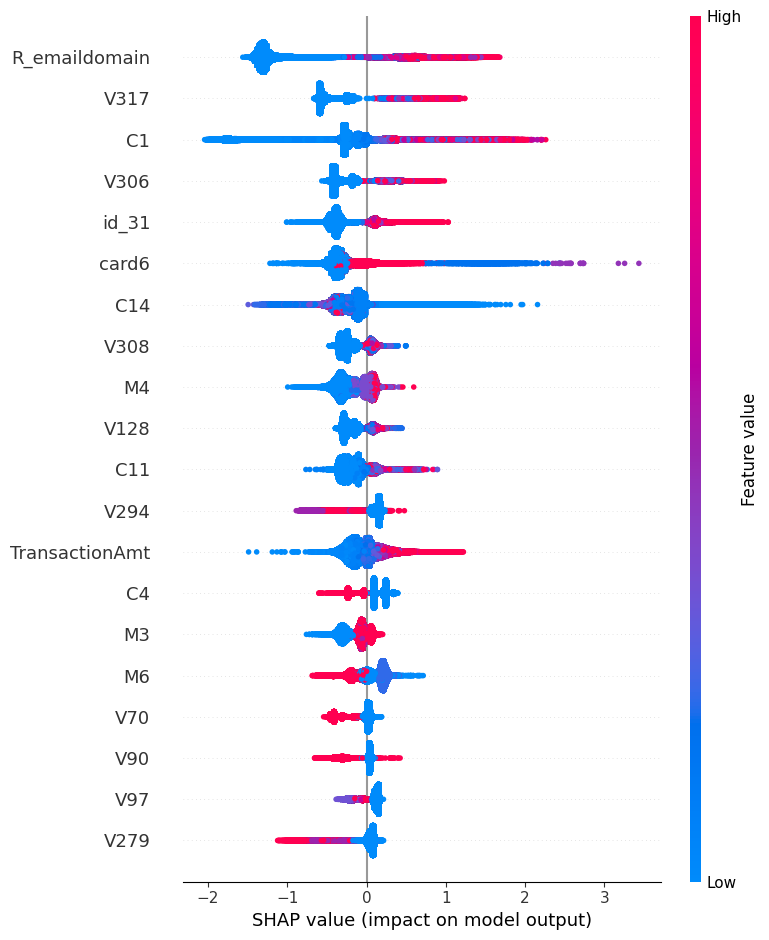

In [30]:
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_mod, show=False)
plt.savefig("xgboost_shap_beeswarm_plot.png")
plt.show()

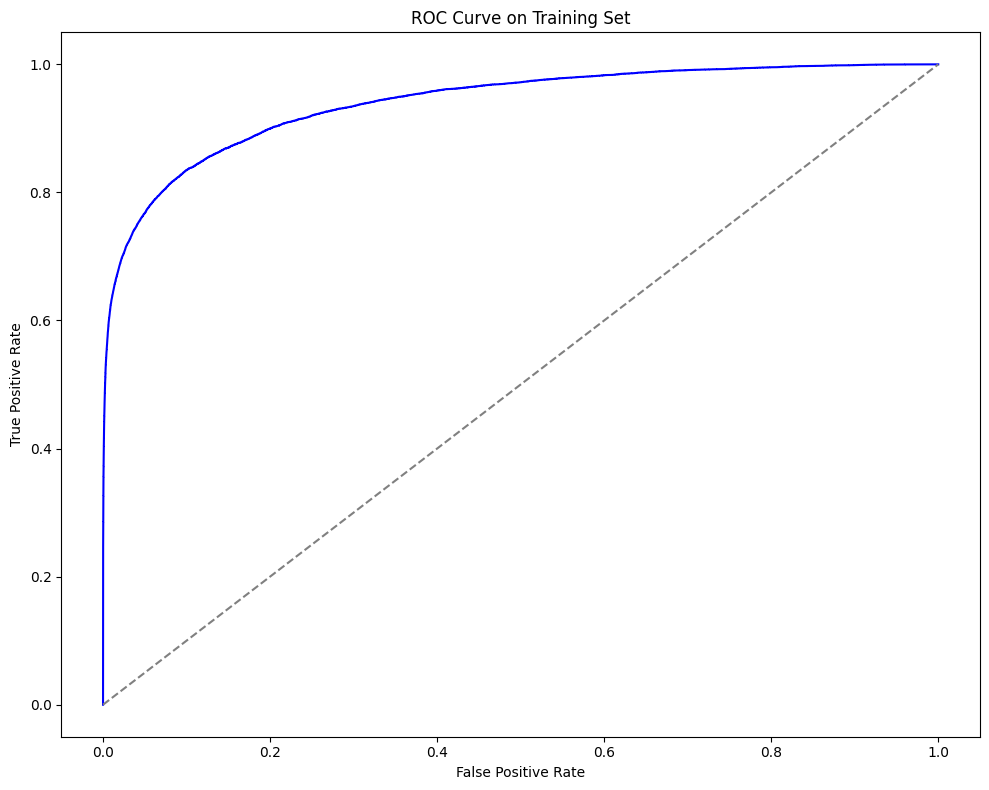

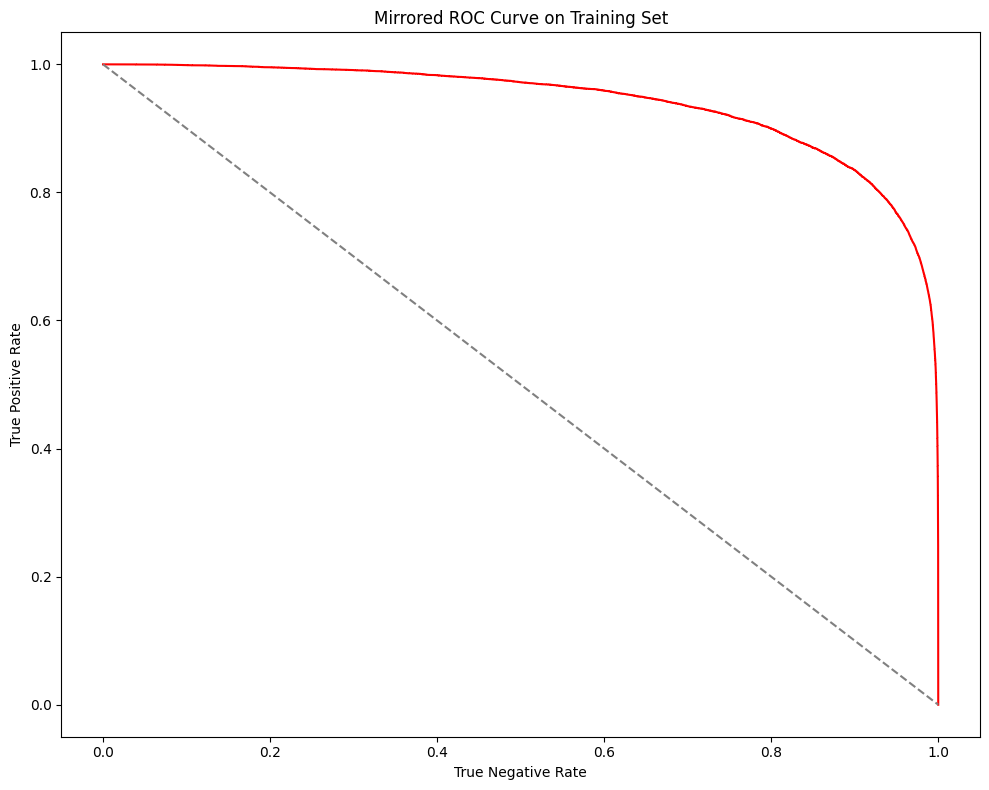

In [35]:
best_pipeline = grid_search.best_estimator_
plot_roc(best_pipeline, X_train, y_train)

In [ ]:
log_custom_pymodel(
    run_name="XGBoost_Prob_ImbLearn_Model_4",
    params=params,
    metrics=metrics,
    best_pipeline=grid_search.best_estimator_,
    figures=["xgboost_shap_bar_plot.png", "xgboost_shap_beeswarm_plot.png", "xgboost_roc_curve.png", "xgboost_roc_curve_mirrored.png"]
)